# Payments Dataset EDA

This notebook explores the synthetic payments dataset generated in Stage 1.

Objectives:
- Understand schema, distributions, and seasonality
- Examine merchant, country, and device patterns
- Inspect fraud labels vs amount and time-of-day
- Produce summary tables for downstream analytics


In [3]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk')

# Paths
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'payments.csv')

# Load
df = pd.read_csv(DATA_PATH, parse_dates=['timestamp'])
print(f"Rows: {len(df):,} | Columns: {len(df.columns)}")
df.head()


Rows: 10,000 | Columns: 9


,transaction_id,user_id,merchant,category,amount,timestamp,is_fraudulent,device_type,country
0,txn_343053424739,684,Spotify,subscription,6.13,2023-01-01 09:43:28+00:00,False,mobile,US
1,txn_684861708880,806,McDonalds,restaurant,23.19,2023-01-01 11:04:39+00:00,False,mobile,US
2,txn_998812657846,961,Spotify,subscription,7.69,2023-01-01 11:25:07+00:00,False,mobile,MX
3,txn_799695611882,369,McDonalds,restaurant,26.02,2023-01-01 11:40:19+00:00,False,mobile,US
4,txn_790627176815,986,Netflix,subscription,12.62,2023-01-01 12:05:01+00:00,False,mobile,US


In [5]:
# Overview & schema
print(df.dtypes)
print()
print("Missing values per column:\n", df.isna().sum())

summary = df.describe(include='all')
summary


transaction_id                 object
user_id                         int64
merchant                       object
category                       object
amount                        float64
timestamp         datetime64[ns, UTC]
is_fraudulent                    bool
device_type                    object
country                        object
dtype: object

Missing values per column:
 transaction_id    0
user_id           0
merchant          0
category          0
amount            0
timestamp         0
is_fraudulent     0
device_type       0
country           0
dtype: int64


,transaction_id,user_id,merchant,category,amount,timestamp,is_fraudulent,device_type,country
count,10000,10000.000000,10000,10000,10000.000000,10000,10000,10000,10000
unique,10000,NaN,23,12,NaN,NaN,2,3,5
top,txn_926811098220,NaN,Amazon,e_commerce,NaN,NaN,False,mobile,US
freq,1,NaN,851,2517,NaN,NaN,9942,6439,5959
mean,NaN,486.577500,NaN,NaN,45.009156,2024-05-29 00:05:01.842400+00:00,NaN,NaN,NaN
min,NaN,1.000000,NaN,NaN,0.620000,2023-01-01 09:43:28+00:00,NaN,NaN,NaN
25%,NaN,228.000000,NaN,NaN,10.527500,2023-09-19 14:35:37.249999872+00:00,NaN,NaN,NaN
50%,NaN,489.000000,NaN,NaN,21.295000,2024-05-27 15:42:15.500000+00:00,NaN,NaN,NaN
75%,NaN,720.000000,NaN,NaN,46.350000,2025-02-06 12:28:49.750000128+00:00,NaN,NaN,NaN
max,NaN,1000.000000,NaN,NaN,1413.980000,2025-10-26 21:10:53+00:00,NaN,NaN,NaN


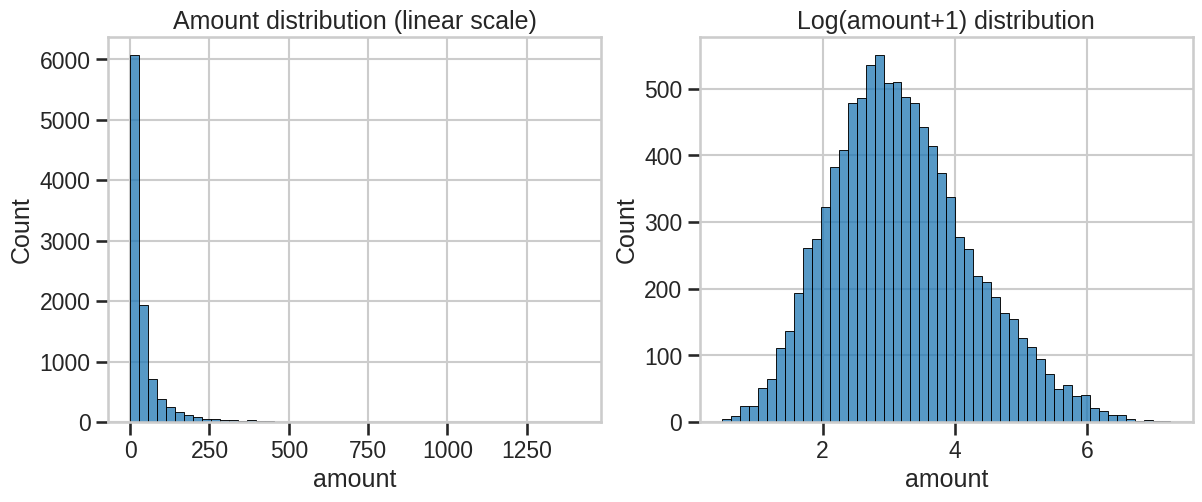

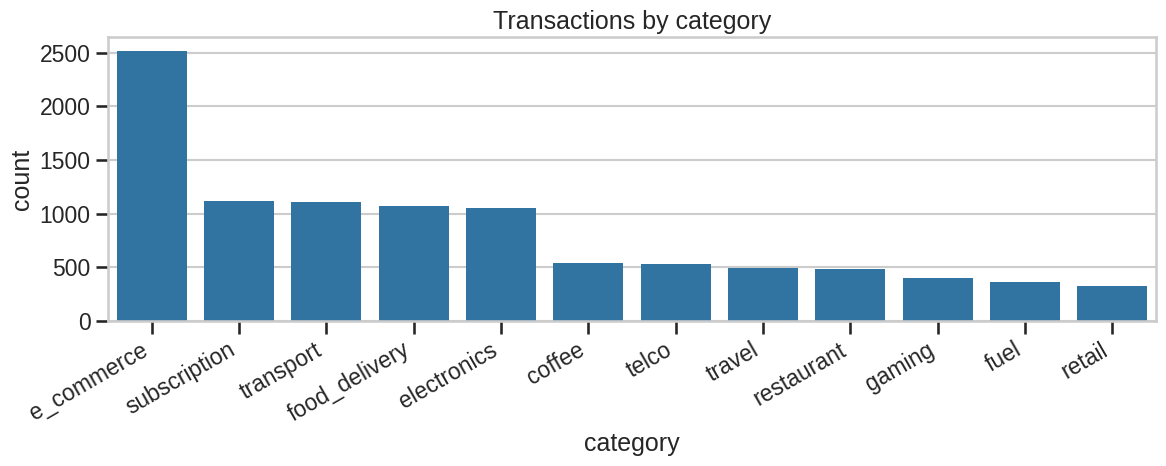

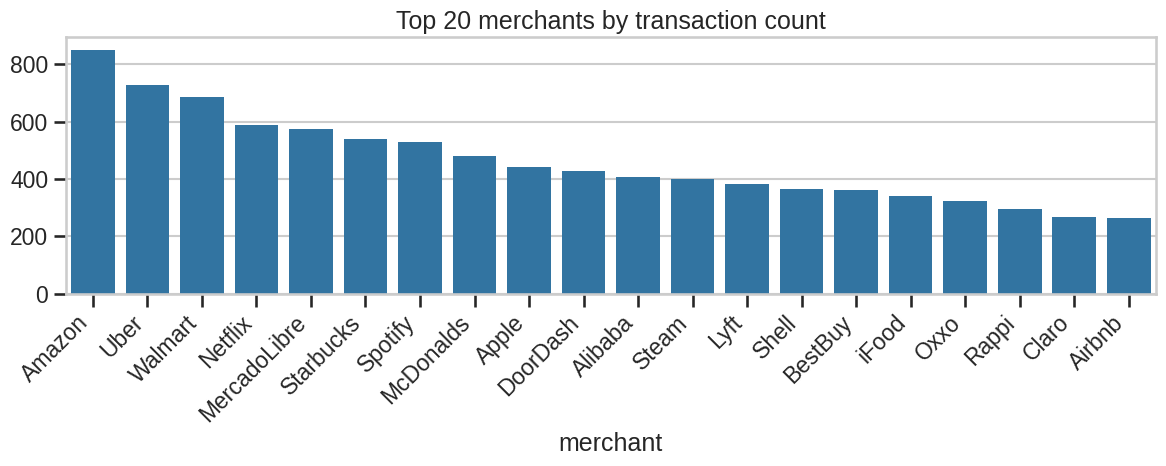

In [6]:
# Distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['amount'], bins=50, ax=axes[0])
axes[0].set_title('Amount distribution (linear scale)')

sns.histplot(np.log1p(df['amount']), bins=50, ax=axes[1])
axes[1].set_title('Log(amount+1) distribution')
plt.show()

# Category share
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='category', order=df['category'].value_counts().index)
plt.xticks(rotation=30, ha='right')
plt.title('Transactions by category')
plt.tight_layout()
plt.show()

# Merchant frequency (top 20)
plt.figure(figsize=(12, 5))
top_merchants = df['merchant'].value_counts().head(20)
sns.barplot(x=top_merchants.index, y=top_merchants.values)
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 merchants by transaction count')
plt.tight_layout()
plt.show()


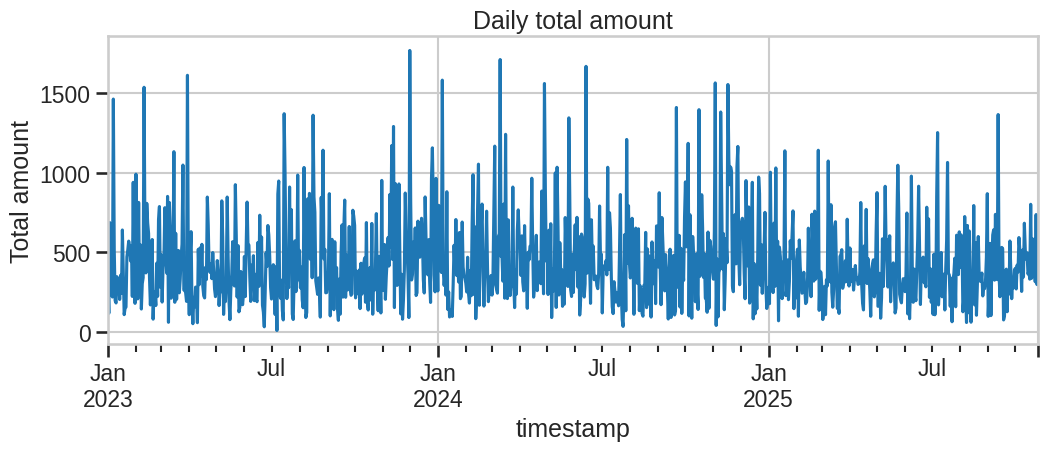

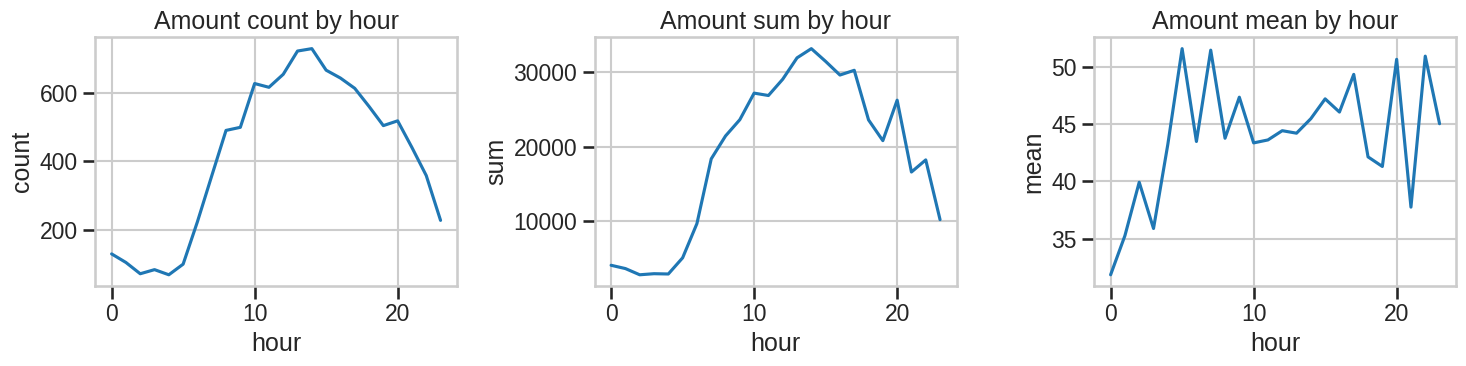

In [7]:
# Time series views
s = df.set_index('timestamp').sort_index()

# By day
by_day = s['amount'].resample('D').sum()
ax = by_day.plot(figsize=(12,4), title='Daily total amount')
ax.set_ylabel('Total amount')
plt.show()

# By hour of day
s['hour'] = s.index.hour
hourly = s.groupby('hour')['amount'].agg(['count','sum','mean'])
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, col in zip(axes, ['count','sum','mean']):
    sns.lineplot(x=hourly.index, y=hourly[col], ax=ax)
    ax.set_title(f'Amount {col} by hour')
plt.tight_layout()
plt.show()


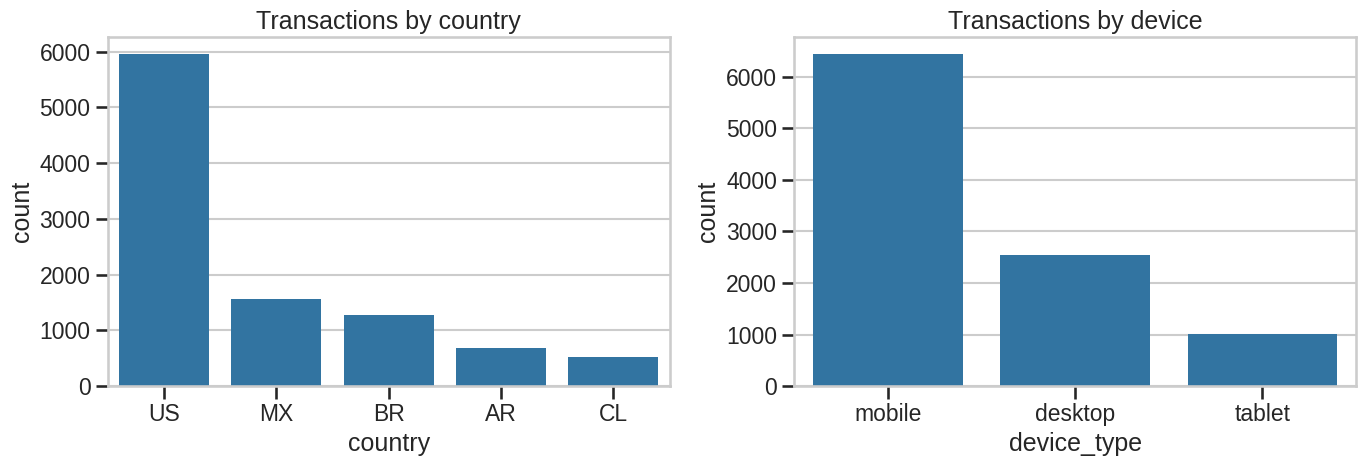

device_type  desktop  mobile  tablet
country                             
AR             40.87   44.83   44.43
BR             40.18   47.74   40.25
CL             36.63   41.17   45.31
MX             53.75   44.50   41.39
US             46.25   45.00   42.57


In [8]:
# Country and device analysis
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.countplot(data=df, x='country', order=df['country'].value_counts().index, ax=axes[0])
axes[0].set_title('Transactions by country')

sns.countplot(data=df, x='device_type', order=df['device_type'].value_counts().index, ax=axes[1])
axes[1].set_title('Transactions by device')
plt.tight_layout()
plt.show()

# Spend per country/device
pivot = df.pivot_table(index='country', columns='device_type', values='amount', aggfunc='mean')
print(pivot.round(2))


Overall fraud rate: 0.580%


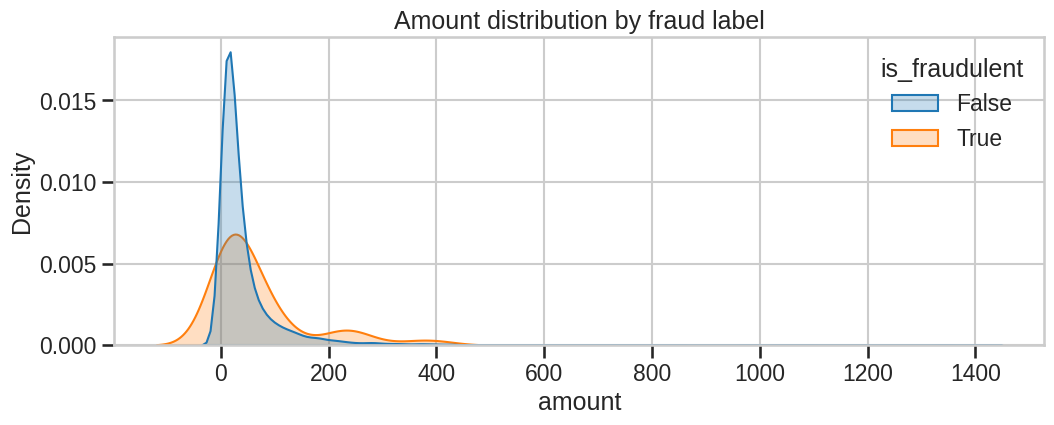

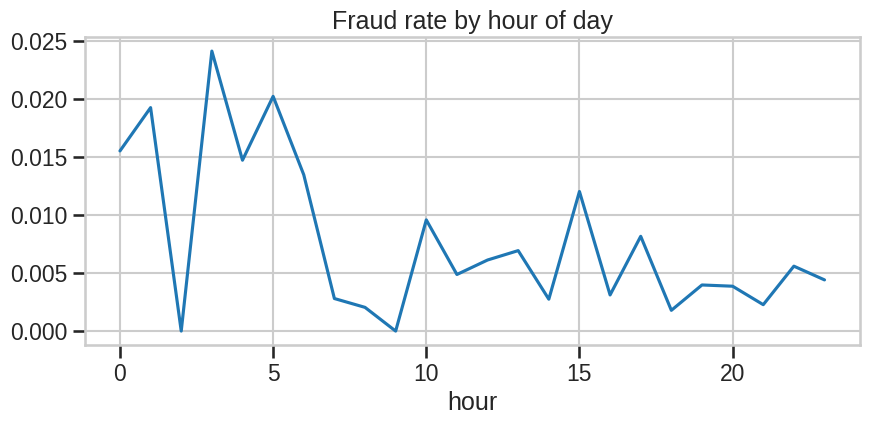

In [9]:
# Fraud analysis
fraud_rate = df['is_fraudulent'].mean()
print(f"Overall fraud rate: {fraud_rate:.3%}")

# Amount vs fraud
plt.figure(figsize=(12,4))
sns.kdeplot(data=df, x='amount', hue='is_fraudulent', common_norm=False, fill=True)
plt.title('Amount distribution by fraud label')
plt.show()

# Hour vs fraud
df['hour'] = df['timestamp'].dt.hour
fraud_by_hour = df.groupby('hour')['is_fraudulent'].mean()
plt.figure(figsize=(10,4))
sns.lineplot(x=fraud_by_hour.index, y=fraud_by_hour.values)
plt.title('Fraud rate by hour of day')
plt.show()


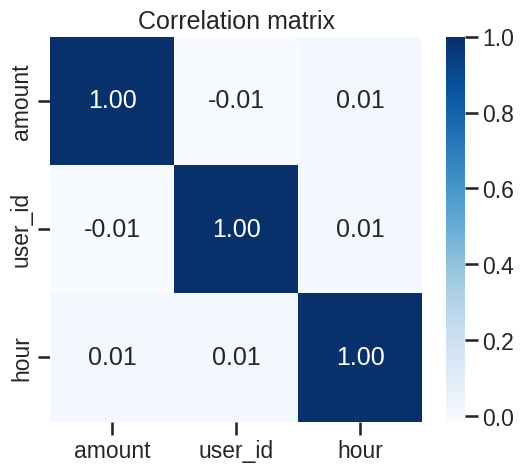

,tx_count,total_amount,avg_amount,fraud_rate
merchant,,,,
Amazon,851,28839.48,33.89,0.0024
Uber,728,13925.10,19.13,0.0055
Walmart,686,23496.57,34.25,0.0044
Netflix,588,6766.36,11.51,0.0085
MercadoLibre,574,19703.43,34.33,0.0052
Starbucks,541,4197.22,7.76,0.0018
Spotify,530,6064.23,11.44,0.0057
McDonalds,480,10136.17,21.12,0.0000
Apple,441,70568.45,160.02,0.0091


In [10]:
# Correlations
numeric_cols = ['amount', 'user_id', 'hour']

corr = df[numeric_cols].corr(numeric_only=True)
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.title('Correlation matrix')
plt.show()

# Merchant performance table
merchant_stats = (
    df.groupby('merchant')
      .agg(tx_count=('transaction_id','count'),
           total_amount=('amount','sum'),
           avg_amount=('amount','mean'),
           fraud_rate=('is_fraudulent','mean'))
      .sort_values('tx_count', ascending=False)
      .head(20)
)
merchant_stats.round({'total_amount': 2, 'avg_amount': 2, 'fraud_rate': 4})


## Notes
- This EDA is intended to validate the realism of the generator.
- For reproducibility, ensure the dataset was generated with a known seed.
- Extend this notebook with charts relevant to your downstream tasks.
